# ASE & CP2K

Set some environment variables for the notebook. For doing this on a HPC resource, these would be set as export commands in the slurm script. Also, the ASE_CP2K_COMMAND would change to "srun cp2k_shell.psmp"

In [59]:
%set_env SHELL=/bin/bash
%set_env OMP_NUM_THREADS=8
%set_env VECLIB_MAXIMUM_THREADS=1
%set_env ASE_CP2K_COMMAND=/Users/Woody/Programs/cp2k/9.1/exe/Darwin-gfortran/cp2k_shell.ssmp

env: SHELL=/bin/bash
env: OMP_NUM_THREADS=8
env: VECLIB_MAXIMUM_THREADS=1
env: ASE_CP2K_COMMAND=/Users/Woody/Programs/cp2k/9.1/exe/Darwin-gfortran/cp2k_shell.ssmp


## Modules

In [60]:
# General
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

# For building things
from ase import Atom, Atoms
from ase.io import read, write
from ase.io.trajectory import Trajectory
from ase.build import molecule
from ase.visualize import view
from ase.db import connect

# Unit Conversions and Fixing Atoms
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal
from ase.constraints import FixedPlane, FixedLine, FixAtoms

# ASE Calculators
from plumed import Plumed
from ase.calculators.cp2k import CP2K
from ase.calculators.lj import LennardJones
from ase.calculators.plumed import Plumed
from ase.calculators.idealgas import IdealGas

# Geometry Optimizations and Normal Mode Analysis
from ase.optimize import LBFGS, FIRE
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo

# EOS fitting for Unit Cells
from ase.eos import EquationOfState, calculate_eos

# Molecular Dynamics
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase.md.npt import NPT

cwd = os.getcwd()
cwd

'/Users/Woody/Documents/Projects/MSELProjects/NSF/SurfacesAndBulk'

In [62]:
def myCP2KCalculator(functional, ecut):
    """Creates a CP2K calculator object with Settings for Production Runs
    tag -> label for cp2k output
    functional -> Either PBE+D3, BEEFVDW, rVV10, or LDA+FermiDirac
    ecut -> PW Kinetic Energy Cutoff (Rydberg)
    """
    
    if functional == "PBE+D3":
        xc = "PBE"
        inp = '''
&GLOBAL
  WALLTIME 47:58:00
&END GLOBAL
&FORCE_EVAL
  &DFT
    SURFACE_DIPOLE_CORRECTION .FALSE.
    SURF_DIP_DIR Z
    &SCF
      &OT .TRUE.
        MINIMIZER DIIS
        PRECONDITIONER FULL_SINGLE_INVERSE
      &END OT
      &OUTER_SCF .TRUE.
        MAX_SCF 50
      &END OUTER_SCF
    &END SCF
    &XC
      &VDW_POTENTIAL
        POTENTIAL_TYPE PAIR_POTENTIAL
        &PAIR_POTENTIAL
          R_CUTOFF 15.0
          TYPE DFTD3
          CALCULATE_C9_TERM .FALSE.
          REFERENCE_FUNCTIONAL PBE
          PARAMETER_FILE_NAME dftd3.dat
        &END PAIR_POTENTIAL
      &END VDW_POTENTIAL
      &XC_GRID
        XC_DERIV NN10_SMOOTH
        XC_SMOOTH_RHO NN10
      &END
    &END XC
  &END DFT
&END FORCE_EVAL
'''
        
    elif functional == "PBE+D3+surface":
        xc = "PBE"
        inp = '''
&GLOBAL
  WALLTIME 47:58:00
&END GLOBAL
&FORCE_EVAL
  &DFT
    SURFACE_DIPOLE_CORRECTION .TRUE.
    SURF_DIP_DIR Z
    &SCF
      &OT .TRUE.
        MINIMIZER DIIS
        PRECONDITIONER FULL_SINGLE_INVERSE
      &END OT
      &OUTER_SCF .TRUE.
        MAX_SCF 50
      &END OUTER_SCF
    &END SCF
    &XC
      &VDW_POTENTIAL
        POTENTIAL_TYPE PAIR_POTENTIAL
        &PAIR_POTENTIAL
          R_CUTOFF 15.0
          TYPE DFTD3
          CALCULATE_C9_TERM .FALSE.
          REFERENCE_FUNCTIONAL PBE
          PARAMETER_FILE_NAME dftd3.dat
        &END PAIR_POTENTIAL
      &END VDW_POTENTIAL
      &XC_GRID
        XC_DERIV NN10_SMOOTH
        XC_SMOOTH_RHO NN10
      &END
    &END XC
  &END DFT
&END FORCE_EVAL
'''
        
    elif functional == "PBE+D3+FermiDirac+MP":
        xc = "PBE"
        inp = '''
&GLOBAL
  WALLTIME 47:58:00
&END GLOBAL
&FORCE_EVAL
  &DFT
    SURFACE_DIPOLE_CORRECTION .FALSE.
    SURF_DIP_DIR Z
    &KPOINTS
        SCHEME MONKHORST-PACK 4 4 4
    &END KPOINTS
    &SCF
      ADDED_MOS 10
      &SMEAR ON
          METHOD FERMI_DIRAC
          ELECTRONIC_TEMPERATURE [K] 300
      &END SMEAR
      &MIXING .TRUE.
          METHOD BROYDEN_MIXING
      &END MIXING
      &OUTER_SCF .TRUE.
        MAX_SCF 50
      &END OUTER_SCF
    &END SCF
    &XC
      &VDW_POTENTIAL
        POTENTIAL_TYPE PAIR_POTENTIAL
        &PAIR_POTENTIAL
          R_CUTOFF 15.0
          TYPE DFTD3
          CALCULATE_C9_TERM .FALSE.
          REFERENCE_FUNCTIONAL PBE
          PARAMETER_FILE_NAME dftd3.dat
        &END PAIR_POTENTIAL
      &END VDW_POTENTIAL
      &XC_GRID
        XC_DERIV NN10_SMOOTH
        XC_SMOOTH_RHO NN10
      &END
    &END XC
  &END DFT
&END FORCE_EVAL
'''
        
    elif functional == "optB88-vdw":
        xc = None
        inp = '''
&GLOBAL
  WALLTIME 47:58:00
&END GLOBAL
&FORCE_EVAL
  &DFT
    SURFACE_DIPOLE_CORRECTION .FALSE.
    SURF_DIP_DIR Z
    &SCF
      &OT .TRUE.
        MINIMIZER DIIS
        PRECONDITIONER FULL_SINGLE_INVERSE
      &END OT
      &OUTER_SCF .TRUE.
        MAX_SCF 50
      &END OUTER_SCF
    &END SCF
     &XC
      &XC_FUNCTIONAL
        &LIBXC
          FUNCTIONAL GGA_X_OPTB88_VDW
        &END LIBXC
        &PW92
        &END PW92
      &END XC_FUNCTIONAL
      &vdW_POTENTIAL
         DISPERSION_FUNCTIONAL NON_LOCAL
         &NON_LOCAL
           TYPE DRSLL
           VERBOSE_OUTPUT
           KERNEL_FILE_NAME vdW_kernel_table.dat
         &END NON_LOCAL
      &END vdW_POTENTIAL
    &END XC
  &END DFT
&END FORCE_EVAL
'''

        
    elif functional == "optB88-vdw+surface":
        xc = None
        inp = '''
&GLOBAL
  WALLTIME 47:58:00
&END GLOBAL
&FORCE_EVAL
  &DFT
    SURFACE_DIPOLE_CORRECTION .TRUE.
    SURF_DIP_DIR Z
    &SCF
      &OT .TRUE.
        MINIMIZER DIIS
        PRECONDITIONER FULL_SINGLE_INVERSE
      &END OT
      &OUTER_SCF .TRUE.
        MAX_SCF 50
      &END OUTER_SCF
    &END SCF
     &XC
      &XC_FUNCTIONAL
        &LIBXC
          FUNCTIONAL GGA_X_OPTB88_VDW
        &END LIBXC
        &PW92
        &END PW92
      &END XC_FUNCTIONAL
      &vdW_POTENTIAL
         DISPERSION_FUNCTIONAL NON_LOCAL
         &NON_LOCAL
           TYPE DRSLL
           VERBOSE_OUTPUT
           KERNEL_FILE_NAME vdW_kernel_table.dat
         &END NON_LOCAL
      &END vdW_POTENTIAL
    &END XC
  &END DFT
&END FORCE_EVAL
'''
    elif functional == "optB86B-vdw":
        xc = None
        inp = '''
&GLOBAL
  WALLTIME 47:58:00
&END GLOBAL
&FORCE_EVAL
  &DFT
    SURFACE_DIPOLE_CORRECTION .FALSE.
    SURF_DIP_DIR Z
    &SCF
      &OT .TRUE.
        MINIMIZER DIIS
        PRECONDITIONER FULL_SINGLE_INVERSE
      &END OT
      &OUTER_SCF .TRUE.
        MAX_SCF 50
      &END OUTER_SCF
    &END SCF
     &XC
      &XC_FUNCTIONAL
        &LIBXC
          FUNCTIONAL GGA_X_OPTB86B_VDW
        &END LIBXC
        &PW92
        &END PW92
      &END XC_FUNCTIONAL
      &vdW_POTENTIAL
         DISPERSION_FUNCTIONAL NON_LOCAL
         &NON_LOCAL
           TYPE DRSLL
           VERBOSE_OUTPUT
           KERNEL_FILE_NAME vdW_kernel_table.dat
         &END NON_LOCAL
      &END vdW_POTENTIAL
    &END XC
  &END DFT
&END FORCE_EVAL
'''
        
    elif functional == "optPBE-vdw":
        xc = None
        inp = '''
&GLOBAL
  WALLTIME 47:58:00
&END GLOBAL
&FORCE_EVAL
  &DFT
    SURFACE_DIPOLE_CORRECTION .FALSE.
    SURF_DIP_DIR Z
    &SCF
      &OT .TRUE.
        MINIMIZER DIIS
        PRECONDITIONER FULL_SINGLE_INVERSE
      &END OT
      &OUTER_SCF .TRUE.
        MAX_SCF 50
      &END OUTER_SCF
    &END SCF
     &XC
      &XC_FUNCTIONAL
        &LIBXC
          FUNCTIONAL GGA_X_OPTPBE_VDW
        &END LIBXC
        &PW92
        &END PW92
      &END XC_FUNCTIONAL
      &vdW_POTENTIAL
         DISPERSION_FUNCTIONAL NON_LOCAL
         &NON_LOCAL
           TYPE DRSLL
           VERBOSE_OUTPUT
           KERNEL_FILE_NAME vdW_kernel_table.dat
         &END NON_LOCAL
      &END vdW_POTENTIAL
    &END XC
  &END DFT
&END FORCE_EVAL
'''
    elif functional == "rVV10":
        xc = None
        inp = '''
&GLOBAL
  WALLTIME 47:58:00
&END GLOBAL
&FORCE_EVAL
  &DFT
    SURFACE_DIPOLE_CORRECTION .FALSE.
    SURF_DIP_DIR Z
    &SCF
      &OT .TRUE.
        MINIMIZER DIIS
        PRECONDITIONER FULL_SINGLE_INVERSE
      &END OT
      &OUTER_SCF .TRUE.
        MAX_SCF 50
      &END OUTER_SCF
    &END SCF
    &XC
       &XC_FUNCTIONAL
         &GGA_X_RPW86
         &END GGA_X_RPW86
         &GGA_C_PBE
         &END GGA_C_PBE
       &END XC_FUNCTIONAL
       &vdW_POTENTIAL
          DISPERSION_FUNCTIONAL NON_LOCAL
          &NON_LOCAL
            TYPE RVV10
            PARAMETERS 6.3 0.0093
            VERBOSE_OUTPUT
            KERNEL_FILE_NAME rVV10_kernel_table.dat
            CUTOFF 40
          &END NON_LOCAL
       &END vdW_POTENTIAL
      &XC_GRID
        XC_DERIV NN10_SMOOTH
        XC_SMOOTH_RHO NN10
      &END
    &END XC
  &END DFT
&END FORCE_EVAL
'''
        
        
    elif functional == "optB86B-vdw+surface":
        xc = None
        inp = '''
&GLOBAL
  WALLTIME 47:58:00
&END GLOBAL
&FORCE_EVAL
  &DFT
    SURFACE_DIPOLE_CORRECTION .TRUE.
    SURF_DIP_DIR Z
    &SCF
      &OT .TRUE.
        MINIMIZER DIIS
        PRECONDITIONER FULL_SINGLE_INVERSE
      &END OT
      &OUTER_SCF .TRUE.
        MAX_SCF 50
      &END OUTER_SCF
    &END SCF
     &XC
      &XC_FUNCTIONAL
        &LIBXC
          FUNCTIONAL GGA_X_OPTB86B_VDW
        &END LIBXC
        &PW92
        &END PW92
      &END XC_FUNCTIONAL
      &vdW_POTENTIAL
         DISPERSION_FUNCTIONAL NON_LOCAL
         &NON_LOCAL
           TYPE DRSLL
           VERBOSE_OUTPUT
           KERNEL_FILE_NAME vdW_kernel_table.dat
         &END NON_LOCAL
      &END vdW_POTENTIAL
    &END XC
  &END DFT
&END FORCE_EVAL
'''
        
    elif functional == "optPBE-vdw+surface":
        xc = None
        inp = '''
&GLOBAL
  WALLTIME 47:58:00
&END GLOBAL
&FORCE_EVAL
  &DFT
    SURFACE_DIPOLE_CORRECTION .TRUE.
    SURF_DIP_DIR Z
    &SCF
      &OT .TRUE.
        MINIMIZER DIIS
        PRECONDITIONER FULL_SINGLE_INVERSE
      &END OT
      &OUTER_SCF .TRUE.
        MAX_SCF 50
      &END OUTER_SCF
    &END SCF
     &XC
      &XC_FUNCTIONAL
        &LIBXC
          FUNCTIONAL GGA_X_OPTPBE_VDW
        &END LIBXC
        &PW92
        &END PW92
      &END XC_FUNCTIONAL
      &vdW_POTENTIAL
         DISPERSION_FUNCTIONAL NON_LOCAL
         &NON_LOCAL
           TYPE DRSLL
           VERBOSE_OUTPUT
           KERNEL_FILE_NAME vdW_kernel_table.dat
         &END NON_LOCAL
      &END vdW_POTENTIAL
    &END XC
  &END DFT
&END FORCE_EVAL
'''
    elif functional == "rVV10+surface":
        xc = None
        inp = '''
&GLOBAL
  WALLTIME 47:58:00
&END GLOBAL
&FORCE_EVAL
  &DFT
    SURFACE_DIPOLE_CORRECTION .TRUE.
    SURF_DIP_DIR Z
    &SCF
      &OT .TRUE.
        MINIMIZER DIIS
        PRECONDITIONER FULL_SINGLE_INVERSE
      &END OT
      &OUTER_SCF .TRUE.
        MAX_SCF 50
      &END OUTER_SCF
    &END SCF
    &XC
       &XC_FUNCTIONAL
         &GGA_X_RPW86
         &END GGA_X_RPW86
         &GGA_C_PBE
         &END GGA_C_PBE
       &END XC_FUNCTIONAL
       &vdW_POTENTIAL
          DISPERSION_FUNCTIONAL NON_LOCAL
          &NON_LOCAL
            TYPE RVV10
            PARAMETERS 6.3 0.0093
            VERBOSE_OUTPUT
            KERNEL_FILE_NAME rVV10_kernel_table.dat
            CUTOFF 40
          &END NON_LOCAL
       &END vdW_POTENTIAL
      &XC_GRID
        XC_DERIV NN10_SMOOTH
        XC_SMOOTH_RHO NN10
      &END
    &END XC
  &END DFT
&END FORCE_EVAL
'''
    elif functional == "optB88-vdw+FermiDirac+MP":
        xc = None
        inp = '''
&GLOBAL
  WALLTIME 47:58:00
&END GLOBAL
&FORCE_EVAL
  &DFT
    SURFACE_DIPOLE_CORRECTION .FALSE.
    SURF_DIP_DIR Z
    &KPOINTS
        SCHEME MONKHORST-PACK 4 4 4
    &END KPOINTS
    &SCF
      ADDED_MOS 10
      &SMEAR ON
          METHOD FERMI_DIRAC
          ELECTRONIC_TEMPERATURE [K] 300
      &END SMEAR
      &MIXING .TRUE.
          METHOD BROYDEN_MIXING
      &END MIXING
      &OUTER_SCF .TRUE.
        MAX_SCF 50
      &END OUTER_SCF
    &END SCF
     &XC
      &XC_FUNCTIONAL
        &LIBXC
          FUNCTIONAL GGA_X_OPTB88_VDW
        &END LIBXC
        &PW92
        &END PW92
      &END XC_FUNCTIONAL
      &vdW_POTENTIAL
         DISPERSION_FUNCTIONAL NON_LOCAL
         &NON_LOCAL
           TYPE DRSLL
           VERBOSE_OUTPUT
           KERNEL_FILE_NAME vdW_kernel_table.dat
         &END NON_LOCAL
      &END vdW_POTENTIAL
    &END XC
  &END DFT
&END FORCE_EVAL
'''
        
    elif functional == "optB86B-vdw+FermiDirac+MP":
        xc = None
        inp = '''
&GLOBAL
  WALLTIME 47:58:00
&END GLOBAL
&FORCE_EVAL
  &DFT
    SURFACE_DIPOLE_CORRECTION .FALSE.
    SURF_DIP_DIR Z
    &KPOINTS
        SCHEME MONKHORST-PACK 4 4 4
    &END KPOINTS
    &SCF
      ADDED_MOS 10
      &SMEAR ON
          METHOD FERMI_DIRAC
          ELECTRONIC_TEMPERATURE [K] 300
      &END SMEAR
      &MIXING .TRUE.
          METHOD BROYDEN_MIXING
      &END MIXING
      &OUTER_SCF .TRUE.
        MAX_SCF 50
      &END OUTER_SCF
    &END SCF
     &XC
      &XC_FUNCTIONAL
        &LIBXC
          FUNCTIONAL GGA_X_OPTB86B_VDW
        &END LIBXC
        &PW92
        &END PW92
      &END XC_FUNCTIONAL
      &vdW_POTENTIAL
         DISPERSION_FUNCTIONAL NON_LOCAL
         &NON_LOCAL
           TYPE DRSLL
           VERBOSE_OUTPUT
           KERNEL_FILE_NAME vdW_kernel_table.dat
         &END NON_LOCAL
      &END vdW_POTENTIAL
    &END XC
  &END DFT
&END FORCE_EVAL
'''
        
    elif functional == "optPBE-vdw+FermiDirac+MP":
        xc = None
        inp = '''
&GLOBAL
  WALLTIME 47:58:00
&END GLOBAL
&FORCE_EVAL
  &DFT
    SURFACE_DIPOLE_CORRECTION .FALSE.
    SURF_DIP_DIR Z
    &KPOINTS
        SCHEME MONKHORST-PACK 4 4 4
    &END KPOINTS
    &SCF
      ADDED_MOS 10
      &SMEAR ON
          METHOD FERMI_DIRAC
          ELECTRONIC_TEMPERATURE [K] 300
      &END SMEAR
      &MIXING .TRUE.
          METHOD BROYDEN_MIXING
      &END MIXING
      &OUTER_SCF .TRUE.
        MAX_SCF 50
      &END OUTER_SCF
    &END SCF
     &XC
      &XC_FUNCTIONAL
        &LIBXC
          FUNCTIONAL GGA_X_OPTPBE_VDW
        &END LIBXC
        &PW92
        &END PW92
      &END XC_FUNCTIONAL
      &vdW_POTENTIAL
         DISPERSION_FUNCTIONAL NON_LOCAL
         &NON_LOCAL
           TYPE DRSLL
           VERBOSE_OUTPUT
           KERNEL_FILE_NAME vdW_kernel_table.dat
         &END NON_LOCAL
      &END vdW_POTENTIAL
    &END XC
  &END DFT
&END FORCE_EVAL
'''
    elif functional == "rVV10+FermiDirac+MP":
        xc = None
        inp = '''
&GLOBAL
  WALLTIME 47:58:00
&END GLOBAL
&FORCE_EVAL
  &DFT
    SURFACE_DIPOLE_CORRECTION .FALSE.
    SURF_DIP_DIR Z
    &KPOINTS
        SCHEME MONKHORST-PACK 4 4 4
    &END KPOINTS
    &SCF
      ADDED_MOS 10
      &SMEAR ON
          METHOD FERMI_DIRAC
          ELECTRONIC_TEMPERATURE [K] 300
      &END SMEAR
      &MIXING .TRUE.
          METHOD BROYDEN_MIXING
      &END MIXING
      &OUTER_SCF .TRUE.
        MAX_SCF 50
      &END OUTER_SCF
    &END SCF
    &XC
       &XC_FUNCTIONAL
         &GGA_X_RPW86
         &END GGA_X_RPW86
         &GGA_C_PBE
         &END GGA_C_PBE
       &END XC_FUNCTIONAL
       &vdW_POTENTIAL
          DISPERSION_FUNCTIONAL NON_LOCAL
          &NON_LOCAL
            TYPE RVV10
            PARAMETERS 6.3 0.0093
            VERBOSE_OUTPUT
            KERNEL_FILE_NAME rVV10_kernel_table.dat
            CUTOFF 40
          &END NON_LOCAL
       &END vdW_POTENTIAL
      &XC_GRID
        XC_DERIV NN10_SMOOTH
        XC_SMOOTH_RHO NN10
      &END
    &END XC
  &END DFT
&END FORCE_EVAL
'''
        
    else:
        xc = "LDA"
        inp = ''''''
        
    calc = CP2K(
        auto_write=False,
        basis_set="DZVP-MOLOPT-SR-GTH",
        basis_set_file="BASIS_MOLOPT",
        charge=0,
        cutoff = ecut*Rydberg,
        debug = False,
        force_eval_method = "Quickstep",
        xc = xc,
        inp = inp,
        max_scf = 50,
        poisson_solver ="auto",
        potential_file = "POTENTIAL",
        pseudo_potential = "GTH-PBE",
        stress_tensor = True,
        print_level = "LOW",
    )
    return calc


## Unit Cell Equation of State Fitting

For finding optimal lattice vectors, ASE can calculate the equation of state for a unit cell.

In [68]:
def MyEOSFitting(atoms, db, fh, functional):
    
    atoms.calc = myCP2KCalculator(functional, 400.0)
    v0 = atoms.get_volume()
    cell0 = atoms.get_cell()
    
    start = time.time()
    eos = calculate_eos(atoms,npoints=5, eps=0.05,trajectory=fh+".traj")
    v, e, B = eos.fit()  # find minimum
    end = time.time()
    elapsed = end - start
    
    # Do one more calculation at the minimum and write to database:
    s = (v/v0)**(1./3.)
    atoms.set_cell(cell0*s, scale_atoms=True)
    atoms.get_potential_energy()
    
    B_GPa = B / kJ * 1.0e24
    
    db.write(atoms, bm=B_GPa, scaler=s, xcfunctional=functional, totaltime=elapsed)
    eos.plot(filename=fh+".png")


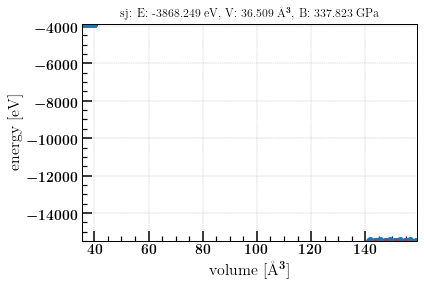

In [69]:
alpha = read("../../Resources/cif/tmc/Alpha-Mo2C_mp-1552_conventional_standard.cif")
beta = read("../../Resources/cif/tmc/Beta-Mo2C_mp-1221498_conventional_standard.cif")

metals = [alpha, beta]
functionals = ["optB88-vdw+FermiDirac+MP", 
               "optB86B-vdw+FermiDirac+MP",
               "optPBE-vdw+FermiDirac+MP",
               "rVV10+FermiDirac+MP",
              "PBE+D3+FermiDirac+MP"]

db = connect('bulk.db')
for m_idx in range(0, len(metals)):
    for f in functionals:
        fh = str(m_idx) + "_" + f
        MyEOSFitting(metals[m_idx],db,fh,f)